In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        self.Epl = np.zeros(len(t))
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = np.array([0.,-9.8])
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a 
        self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            
            # Falta implementar energía potencial 
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        self.Epl[i] = 9.81*self.r[1]
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    def GetPotentialEnergy(self,scale=1):
        return self.Epl[::scale] 
    
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i]*0.9
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i]*0.9

In [3]:
def GetParticles(N,t):
    
    r0 = np.array([-15.,-10.])
    v0 = np.array([2.,0.])
    a0 = np.array([0.,0])
    

    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)

    Particles = [p0]
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [4]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [5]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [6]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 30000/30000 [00:00<00:00, 52584.05 Steps/s]


In [7]:
# Bajamos dimensión de la simulacion
scale = 100
t1 = t[::scale]

<IPython.core.display.Javascript object>


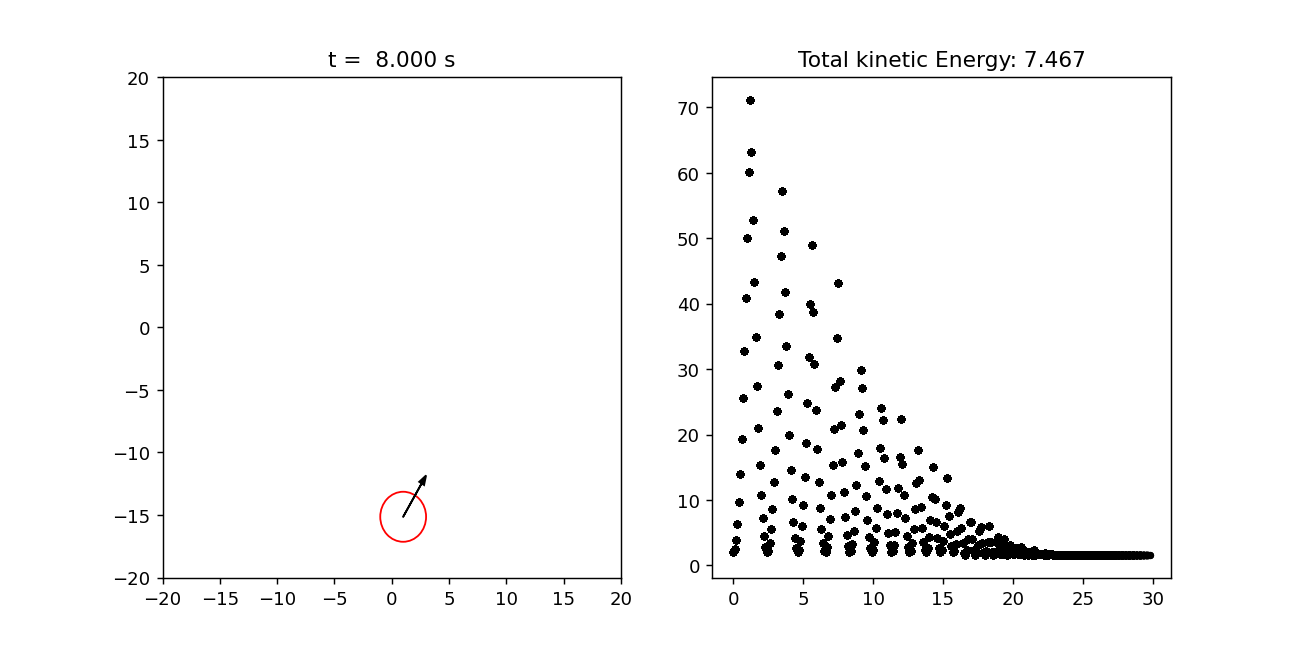

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [26]:
def Momento_angularZ(Particles,t):
    MomentoZ= np.zeros(len(t))
    
    P=Particles[0]
        
    Momento= np.zeros((len(t)))
    
    
    
    for X in range(len(P.GetPosition(100))):
        
        Momento[X]=np.cross(P.GetPosition(100)[X],P.GetVelocity(100)[X])
        
        MomentoZ= np.add(MomentoZ , Momento)
    return MomentoZ
    

Momento_angularZ_=Momento_angularZ(Particles,t1)

In [42]:
MomentumT = Particles[0].GetMomentum(scale)
KineticE= Particles[0].GetKineticEnergy(scale)
PotentialE= Particles[0].GetPotentialEnergy(scale)
Fy=9.8 #m*g
Fx=0 #No hay fuerzas en X
y=[]
for i in range(len(Particles[0].GetVelocity())):
    y.append(Particles[0].GetVelocity()[i][1])

maximos = []
for i in range(1, len(y) - 1):
    if y[i] > y[i - 1] and y[i] > y[i + 1]:
        maximos.append(y[i])
print("diferencia de maximos en el eje y da la constante", maximos[1]-maximos[2])


diferencia de maximos en el eje y da la constante 1.0206504000000134


In [28]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))
for i in range(1,len(Particles)):
    KineticE = np.add(KineticE, Particles[i].GetKineticEnergy(scale))
for i in range(1,len(Particles)):
    PotentialE = np.add(PotentialE, Particles[i].GetPotentialEnergy(scale))
ET=np.add(KineticE, PotentialE) 

<IPython.core.display.Javascript object>


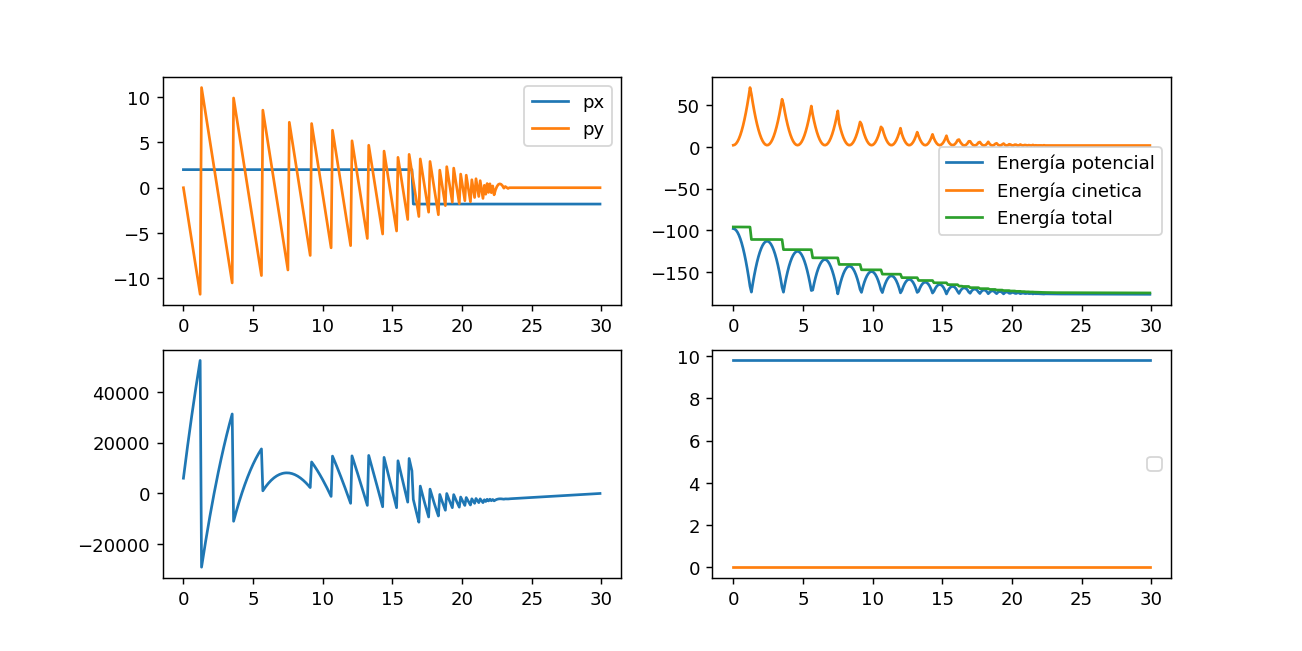

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [55]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()

#fig4 = plt.figure()
#ax4 = fig4.add_subplot(221)
#ax4.plot(t1,KineticE,label='Energía cinetica')
#ax3.legend()


ax5 = fig3.add_subplot(222)
ax5.plot(t1,PotentialE,label='Energía potencial')
ax5.plot(t1,KineticE,label='Energía cinetica')
ax5.plot(t1,ET,label="Energía total")



ax5.legend()


ax4 = fig3.add_subplot(223)
ax4.plot(t1,Momento_angularZ_,label='Momento angular z')
ax3.legend()

Fx=[]
Fy=[]
for i in range(len(t1)):
    Fx.append(0)
    Fy.append(9.8)
ax5 = fig3.add_subplot(224)
ax5.plot(t1,Fy)
ax5.plot(t1,Fx)
ax5.legend()



In [ ]:
M=9999999999999999999999999999999999999999999999
T=0
P=Particles[0]

for i in range(50,len(t)):
    
    V=P.GetVelocity()[i]
    print(V)
    if abs(V[1])<abs(M):
        M=abs(V[1])
        T=t[i]
        
print("Velocidad en y minima:", M)
print("Tiempo cuando la pelota deja de rebotar:",T)